In [5]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_sbi

ModuleNotFoundError: No module named 'tfl_training_sbi'

In [6]:
%presentation_style

UsageError: Line magic function `%presentation_style` not found.


In [ ]:
%%capture

%set_random_seed 12

In [ ]:
%load_latex_macros

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">
    <h1>Evaluating simulation-based inference</h1>
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import torch

from torch import Tensor, log, ones, zeros
from typing import Callable

from tfl_training_sbi.config import (
    default_remote_storage,
    get_config,
    root_dir,
)
from tfl_training_sbi.data_utils import (
    SIRSimulation,
    load_sir_data,
)

storage = default_remote_storage()
c = get_config(reload=True)

## How can we evaluate the performance of SBI?


- Neural density estimators are accurate only in the limit of infinite training data
- The posteriors we get are only approximations
- How do we know SBI is reliable? 

## Methods to evaluate the performance of SBI


1) Checking neural network training convergence
    - Monitor posterior log-probability of test data pairs $(\theta, x)$ 
2) Posterior predictive checks
    - Test whether the inferred parameters $\theta \sim q(\theta | x_o)$ reproduce the observed data $x_o$
3) Calibration checks
    - Check whether the uncertainties of the inferred posteriors are well-calibrated 


## 1) Neural network training convergence

- Use logging tools like `lightning`, `tensorboard` or `wandb` (weights and biases, wandb.ai) to track training convergence via the validation loss. 
- Validation loss: use unseen data simulated from the prior to evaluate the conditional density estimator: 

```python
validation_loss = -net.log_prob(theta, x)  # - log p(theta | x)
```

- Stop training when `validation_loss` converges (e.g., no decrease for 20 epochs)
```python
trainer = SNPE().append_simulations(theta, x)
net = trainer.train(validation_fractior=0.2, stop_after_epochs=20)

```
- Use `validation_loss` to perform neural architecture search (e.g., for embedding nets)

## Gaussian example

In [2]:
import torch
from torch import Tensor, ones, zeros
from sbi.inference import SNPE
from sbi.utils import BoxUniform
from sbi.analysis import pairplot

In [3]:
def simulator(theta: Tensor, simulator_scale: float = 0.1) -> Tensor:
    return simulator_scale * torch.randn_like(theta) + theta

# choose prior
dim = 2
prior = BoxUniform(-ones(dim), ones(dim))

# run simulations
num_simulations = 2000
theta = prior.sample((num_simulations,))
x = simulator(theta)

# train
trainer = SNPE(prior).append_simulations(theta, x)
trainer.train()
posterior = trainer.build_posterior()

 Neural network successfully converged after 79 epochs.

## 1) Check training convergence

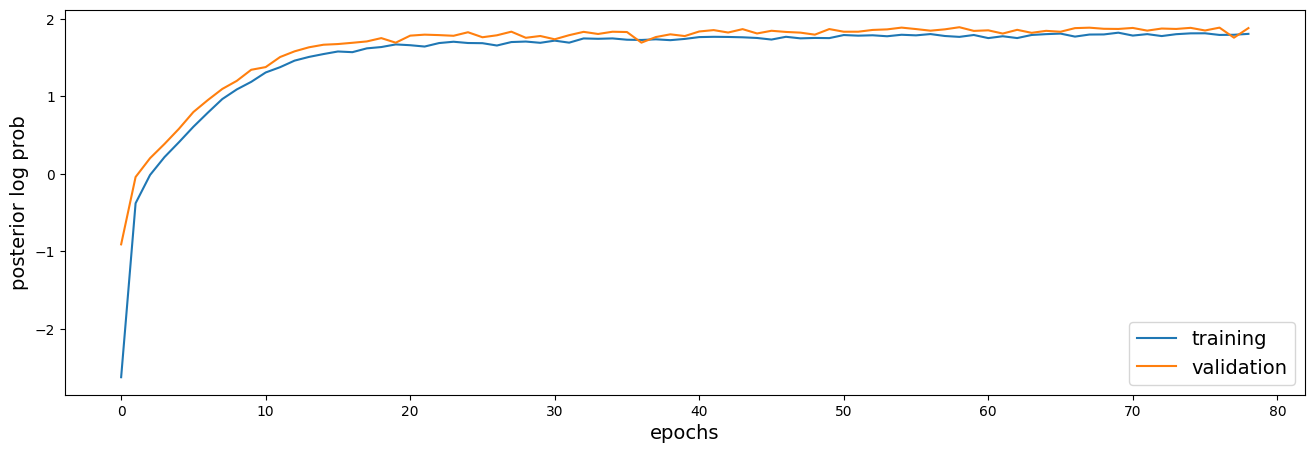

In [4]:
fontsize = 14
plt.figure(figsize=(16, 5))
plt.plot(trainer.summary["training_log_probs"])
plt.plot(trainer.summary["validation_log_probs"])
plt.xlabel("epochs", fontsize=fontsize)
plt.ylabel("posterior log prob", fontsize=fontsize)
plt.legend(["training", "validation"], fontsize=fontsize);

## Visualize posterior

Parameter space

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

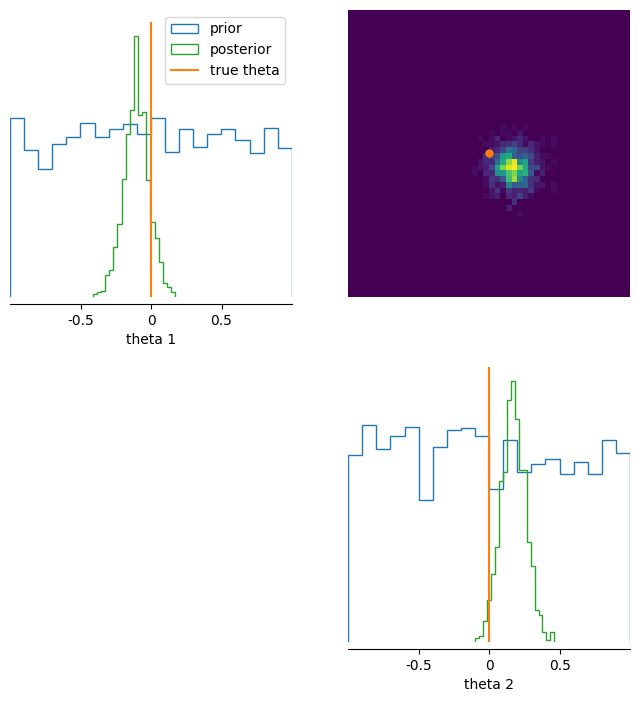

In [5]:
theta_o = zeros(dim)
x_o = simulator(theta_o)
num_samples = 1000
posterior_samples = posterior.sample((num_samples,), x=x_o)

pairplot([theta, posterior_samples], points=theta_o, 
         labels=["theta 1", "theta 2"], samples_labels=["prior", "posterior"], 
         points_labels=["true theta"], legend=True, hist_diag=dict(bins=20), figsize=(8, 8),
        );

## 2) Posterior predictive checks

- The posterior characterizes those model parameters that are likely to have generate the observed data $x_o$
- Thus, simulating data with inferred parameters should reproduce $x_o$ ($\pm$ simulator noise)
- Posterior predictive checks: 
    - Simulate data with parameters sampled from the posterior
    - Visually or quantitatively compare to $x_o$
    - If they do not match, something is off! 

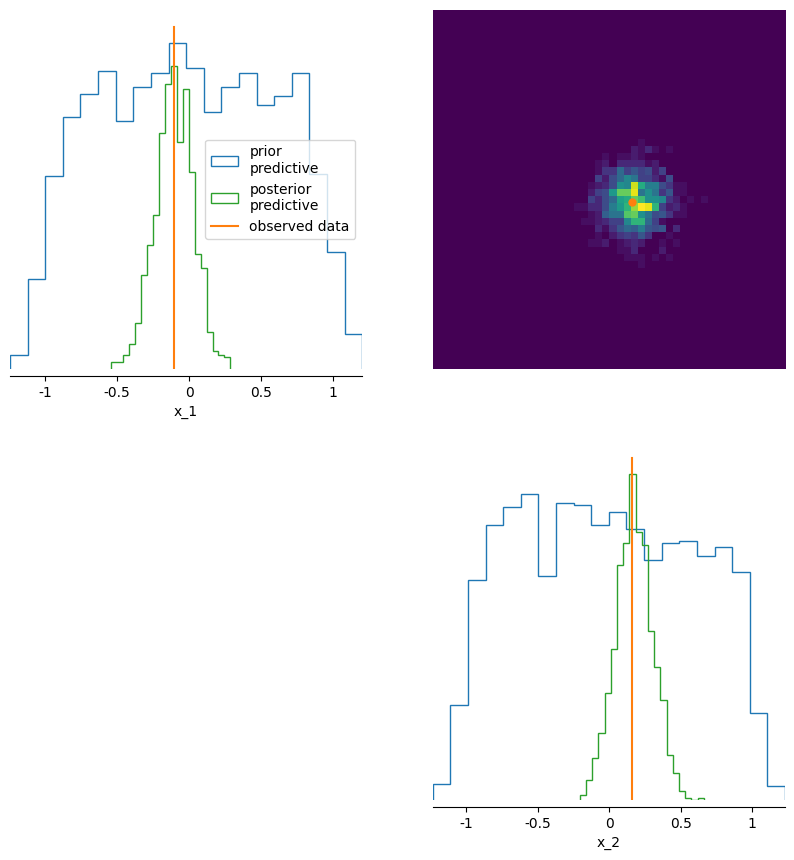

In [6]:
posterior_predictive_samples = simulator(posterior_samples)
pairplot([x, posterior_predictive_samples], points=x_o, labels=["x_1", "x_2"], legend=True,
         samples_labels=["prior\npredictive", "posterior\npredictive"], points_labels=["observed data"], 
         hist_diag=dict(bins=20),
        );

## 3) Posterior calibration checks

- Check whether the SBI posterior uncertainties are well-calibrated: whether the posterior is over- or underconfident (on average)
- Indirect check: we do not need access to the true posterior
- Requirements 
    - Access to a set of unseen test data $(\theta, x)$ (~100s)
    - Fast inference for each test data point (computationally feasible only for amortized SBI methods)
    - Fast posterior sampling (computationally demanding for NLE / NRE). 

## Simulation-based calibration

### Rough idea

- Repeat inference many times with different test data pairs $(\theta_i, x_i)$

$$
\begin{align}
    \theta^* &\sim p(\theta)\\
    x^* &\sim p(x | \theta^*)\\
    \{\theta_1, \ldots \theta_L\} &\sim p_i(\theta | x^*)\\
\end{align}
$$

- Calculate the rank of $\theta_i$ under corresponding posterior $p_i(\theta | x_i)$

$$
\begin{align}
    r_i = \sum_{j=1}^L \mathbb{I}[f(\theta_j) < f(\theta_i^*)] \in [0, L], 
\end{align}
$$

- Check whether distribution of ranks is uniform

## Simulation-based calibration

### Intuition

- There is uncertainty in the simulator (aleatoric) and in the data (epistemic)
- Posterior is **not centered on true parameter**
- But should be somewhere within the posterior (randomly)
- On average, it should be everywhere within posterior mass (uniform ranks)

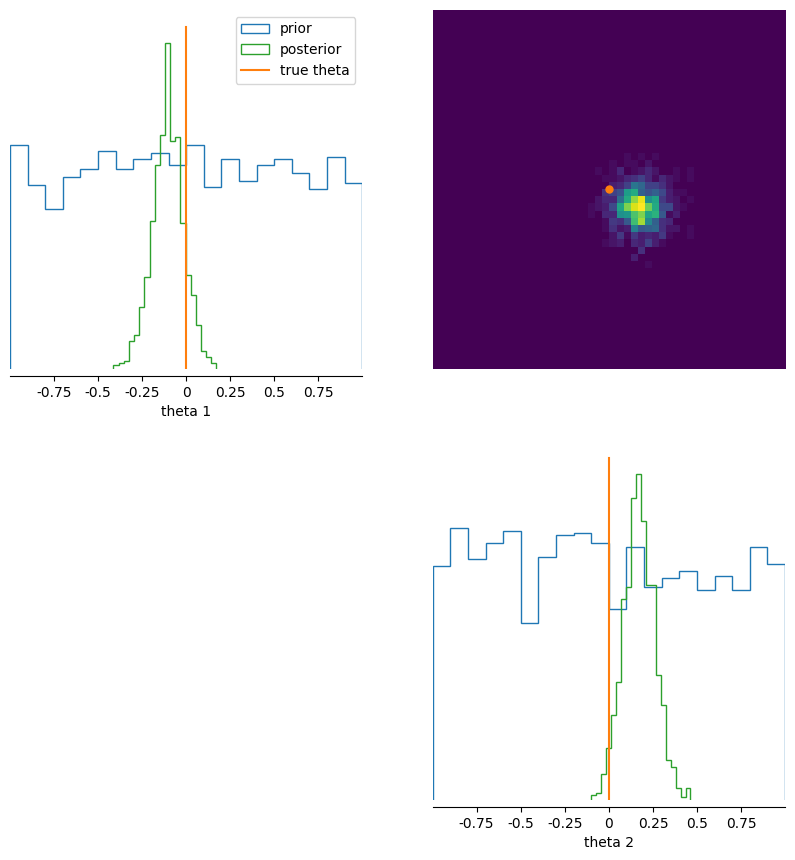

In [7]:
pairplot([theta, posterior_samples], points=theta_o, labels=["theta 1", "theta 2"],
         samples_labels=["prior", "posterior"], points_labels=["true theta"],
         legend=True, hist_diag=dict(bins=20),
        );

## Simulation-based calibration

### Interpretation
<img src="_static/images/fig2.4_sbc_illustration.png" alt="Snow" style="width:50%;">

- The posterior is **well-calibrated** only if the ranks are distributed uniformly (necessary condition)
- Shape of rank-distribution gives insight about **mis-calibration**
- Can be gamed by setting posterior=prior (it's not a sufficient condition)



## Example: applying SBC to Gaussian simulator from above

In [8]:
# generate test data set from prior
num_sbc_simulations = 1000
num_posterior_samples = 1000
theta_test = prior.sample((num_sbc_simulations,))
x_test = simulator(theta_test, simulator_scale=0.1)

# run SBC
from sbi.analysis import run_sbc, sbc_rank_plot

ranks, dap_samples = run_sbc(theta_test, x_test, posterior, num_posterior_samples=num_posterior_samples)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

## Plot the ranks as an empirical CDF

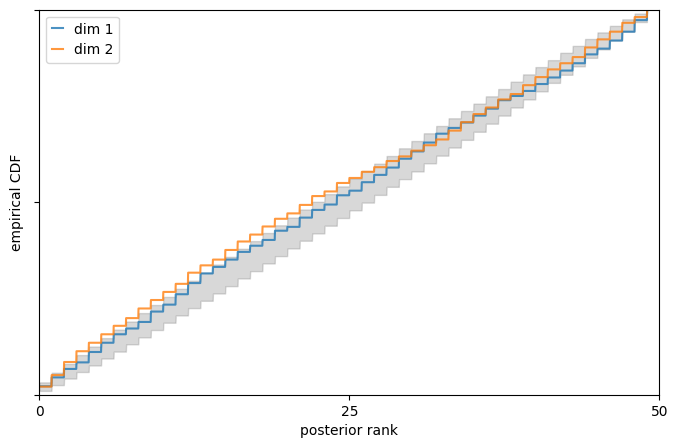

In [9]:
fig, ax = sbc_rank_plot(ranks, num_posterior_samples)

## Exercise: detecting mis-calibration using SBC

Note: the posterior estimator was trained on data with `simulator_scale=0.1`

1) Task 1: generate slightly mis-specified test data by using `simulator_scale=0.05`
2) Task 2: run SBC using that test data and plot the distribution of ranks.
3) Task 3: interpret the results

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

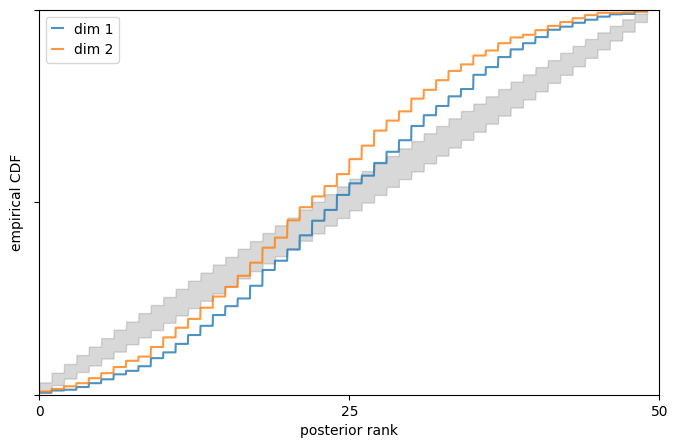

In [10]:
# Solution
theta_test = prior.sample((num_sbc_simulations,))
x_test = simulator(theta_test, simulator_scale=0.05)

ranks, dap_samples = run_sbc(theta_test, x_test, posterior, num_posterior_samples=num_posterior_samples)
fig, ax = sbc_rank_plot(ranks, num_posterior_samples)

## Summary

### Reason for SBI evaluation

- Training data is limited
- SBI posteriors are approximate, 
- No access to ground-truth posterior

### Methods for SBI evaluation

1) Checking training convergence of neural-networks via validation-loss (optimize architectures)
2) Posterior predictive checks: test whether data simulator from the posterior matches observation (sufficient)
3) Calibration checks: test whether posterior-uncertainties are well-calibrated

## Acknowledgments

- SBI package for code and figures.
- Talts et al. 2018 for Simulation-based calibration paper.
- SBC intuition figure taken from Jan Boelts' phd thesis.

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Thank you for the attention!</div>